# Collaborative filtering on Google Analytics data

This notebook demonstrates how to implement a WALS matrix refactorization approach to do collaborative filtering.

In [1]:
import os
PROJECT = "cloud-training-demos" # REPLACE WITH YOUR PROJECT ID
BUCKET = "cloud-training-demos-ml" # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = "1.13"

In [2]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [3]:
import tensorflow as tf
print(tf.__version__)

1.13.1


## Create raw dataset
<p>
For collaborative filtering, we don't need to know anything about either the users or the content. Essentially, all we need to know is userId, itemId, and rating that the particular user gave the particular item.
<p>
In this case, we are working with newspaper articles. The company doesn't ask their users to rate the articles. However, we can use the time-spent on the page as a proxy for rating.
<p>
Normally, we would also add a time filter to this ("latest 7 days"), but our dataset is itself limited to a few days.

In [4]:
from google.cloud import bigquery
bq = bigquery.Client(project = PROJECT)

sql = """
#standardSQL
WITH CTE_visitor_page_content AS (
    SELECT
        fullVisitorID,
        (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) AS latestContentId,  
        (LEAD(hits.time, 1) OVER (PARTITION BY fullVisitorId ORDER BY hits.time ASC) - hits.time) AS session_duration 
    FROM
        `cloud-training-demos.GA360_test.ga_sessions_sample`,   
        UNNEST(hits) AS hits
    WHERE 
        # only include hits on pages
        hits.type = "PAGE"

    GROUP BY   
        fullVisitorId,
        latestContentId,
        hits.time )

-- Aggregate web stats
SELECT   
    fullVisitorID as visitorId,
    latestContentId as contentId,
    SUM(session_duration) AS session_duration
FROM
    CTE_visitor_page_content
WHERE
    latestContentId IS NOT NULL 
GROUP BY
    fullVisitorID, 
    latestContentId
HAVING 
    session_duration > 0
ORDER BY 
    latestContentId 
"""

df = bq.query(sql).to_dataframe()
df.head()

,visitorId,contentId,session_duration
0,7337153711992174438,100074831,44652
1,5190801220865459604,100170790,1214205
2,5874973374932455844,100510126,32109
3,2293633612703952721,100510126,47744
4,1173698801255170595,100676857,10512


In [5]:
stats = df.describe()
stats

,session_duration
count,2.789130e+05
mean,1.272188e+05
std,2.346439e+05
min,1.000000e+00
25%,1.709500e+04
50%,5.793800e+04
75%,1.293930e+05
max,7.690598e+06


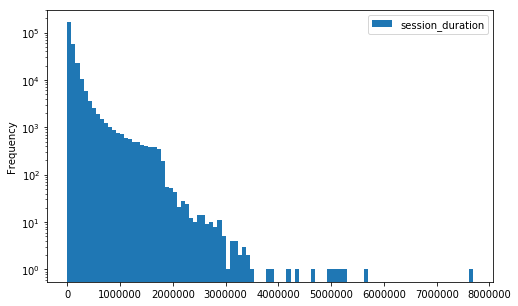

In [6]:
df[["session_duration"]].plot(kind="hist", logy=True, bins=100, figsize=[8,5])

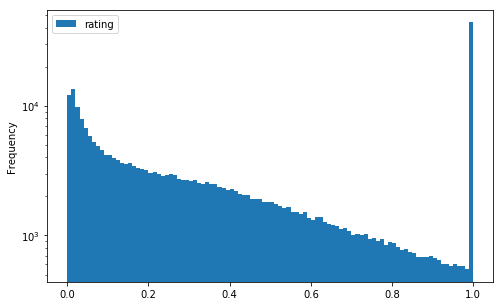

In [7]:
# The rating is the session_duration scaled to be in the range 0-1.  This will help with training.
median = stats.loc["50%", "session_duration"]
df["rating"] = 0.3 * df["session_duration"] / median
df.loc[df["rating"] > 1, "rating"] = 1
df[["rating"]].plot(kind="hist", logy=True, bins=100, figsize=[8,5])

In [8]:
del df["session_duration"]

In [9]:
%%bash
rm -rf data
mkdir data

In [10]:
df.to_csv(path_or_buf = "data/collab_raw.csv", index = False, header = False)

In [11]:
!head data/collab_raw.csv

7337153711992174438,100074831,0.23120577168697573
5190801220865459604,100170790,1.0
5874973374932455844,100510126,0.16625875936345746
2293633612703952721,100510126,0.24721598950602366
1173698801255170595,100676857,0.054430598225689526
7262596434087807556,100735153,0.23134039835686424
883397426232997550,10083328,0.9450274431288619
1808867070685560283,100906145,1.0
7615995624631762562,100906145,0.48231040077324033
5519169380728479914,100915139,0.199485657081708


## Create dataset for WALS
<p>
The raw dataset (above) won't work for WALS:
<ol>
<li> The userId and itemId have to be 0,1,2 ... so we need to create a mapping from visitorId (in the raw data) to userId and contentId (in the raw data) to itemId.
<li> We will need to save the above mapping to a file because at prediction time, we'll need to know how to map the contentId in the table above to the itemId.
<li> We'll need two files: a "rows" dataset where all the items for a particular user are listed; and a "columns" dataset where all the users for a particular item are listed.
</ol>

<p>

### Mapping

In [12]:
import pandas as pd
import numpy as np
def create_mapping(values, filename):
    with open(filename, 'w') as ofp:
        value_to_id = {value:idx for idx, value in enumerate(values.unique())}
        for value, idx in value_to_id.items():
            ofp.write("{},{}\n".format(value, idx))
    return value_to_id

df = pd.read_csv(filepath_or_buffer = "data/collab_raw.csv",
                 header = None,
                 names = ["visitorId", "contentId", "rating"],
                dtype = {"visitorId": str, "contentId": str, "rating": np.float})
df.to_csv(path_or_buf = "data/collab_raw.csv", index = False, header = False)
user_mapping = create_mapping(df["visitorId"], "data/users.csv")
item_mapping = create_mapping(df["contentId"], "data/items.csv")

In [13]:
!head -3 data/*.csv

==> data/collab_raw.csv <==
7337153711992174438,100074831,0.2312057716869757
5190801220865459604,100170790,1.0
5874973374932455844,100510126,0.16625875936345744

==> data/items.csv <==
222179340,1120
279842606,2411
294040727,3149

==> data/users.csv <==
4549384023202555350,21998
7584794121749625957,14497
4605309638477121627,7508


In [14]:
df["userId"] = df["visitorId"].map(user_mapping.get)
df["itemId"] = df["contentId"].map(item_mapping.get)

In [15]:
mapped_df = df[["userId", "itemId", "rating"]]
mapped_df.to_csv(path_or_buf = "data/collab_mapped.csv", index = False, header = False)
mapped_df.head()

,userId,itemId,rating
0,0,0,0.231206
1,1,1,1.000000
2,2,2,0.166259
3,3,2,0.247216
4,4,3,0.054431


### Creating rows and columns datasets

In [16]:
import pandas as pd
import numpy as np
mapped_df = pd.read_csv(filepath_or_buffer = "data/collab_mapped.csv", header = None, names = ["userId", "itemId", "rating"])
mapped_df.head()

,userId,itemId,rating
0,0,0,0.231206
1,1,1,1.000000
2,2,2,0.166259
3,3,2,0.247216
4,4,3,0.054431


In [17]:
NITEMS = np.max(mapped_df["itemId"]) + 1
NUSERS = np.max(mapped_df["userId"]) + 1
mapped_df["rating"] = np.round(mapped_df["rating"].values, 2)
print("{} items, {} users, {} interactions".format( NITEMS, NUSERS, len(mapped_df) ))

5668 items, 82802 users, 278913 interactions


In [18]:
grouped_by_items = mapped_df.groupby("itemId")
iter = 0
for item, grouped in grouped_by_items:
    print(item, grouped["userId"].values, grouped["rating"].values)
    iter = iter + 1
    if iter > 5:
        break

0 [0] [0.23]
1 [1] [1.]
2 [2 3] [0.17 0.25]
3 [4] [0.05]
4 [5] [0.23]
5 [6] [0.95]


In [19]:
import tensorflow as tf
grouped_by_items = mapped_df.groupby("itemId")
with tf.python_io.TFRecordWriter("data/users_for_item") as ofp:
    for item, grouped in grouped_by_items:
        example = tf.train.Example(features = tf.train.Features(feature = {
            "key": tf.train.Feature(int64_list = tf.train.Int64List(value = [item])),
            "indices": tf.train.Feature(int64_list = tf.train.Int64List(value = grouped["userId"].values)),
            "values": tf.train.Feature(float_list = tf.train.FloatList(value = grouped["rating"].values))
        }))
        ofp.write(example.SerializeToString())

In [20]:
grouped_by_users = mapped_df.groupby("userId")
with tf.python_io.TFRecordWriter("data/items_for_user") as ofp:
    for user, grouped in grouped_by_users:
        example = tf.train.Example(features = tf.train.Features(feature = {
            "key": tf.train.Feature(int64_list = tf.train.Int64List(value = [user])),
            "indices": tf.train.Feature(int64_list = tf.train.Int64List(value = grouped["itemId"].values)),
            "values": tf.train.Feature(float_list = tf.train.FloatList(value = grouped["rating"].values))
        }))
        ofp.write(example.SerializeToString())

In [21]:
!ls -lrt data

total 31836
-rw-r--r-- 1 jupyter jupyter 13122162 Apr 16 04:13 collab_raw.csv
-rw-r--r-- 1 jupyter jupyter  2131923 Apr 16 04:13 users.csv
-rw-r--r-- 1 jupyter jupyter    82193 Apr 16 04:13 items.csv
-rw-r--r-- 1 jupyter jupyter  7794933 Apr 16 04:13 collab_mapped.csv
-rw-r--r-- 1 jupyter jupyter  2244880 Apr 16 04:13 users_for_item
-rw-r--r-- 1 jupyter jupyter  7207025 Apr 16 04:14 items_for_user


To summarize, we created the following data files from collab_raw.csv:
<ol>
<li> ```collab_mapped.csv``` is essentially the same data as in ```collab_raw.csv``` except that ```visitorId``` and ```contentId``` which are business-specific have been mapped to ```userId``` and ```itemId``` which are enumerated in 0,1,2,....  The mappings themselves are stored in ```items.csv``` and ```users.csv``` so that they can be used during inference.
<li> ```users_for_item``` contains all the users/ratings for each item in TFExample format
<li> ```items_for_user``` contains all the items/ratings for each user in TFExample format
</ol>

## Train with WALS

Once you have the dataset, do matrix factorization with WALS using the [WALSMatrixFactorization](https://www.tensorflow.org/versions/master/api_docs/python/tf/contrib/factorization/WALSMatrixFactorization) in the contrib directory.
This is an estimator model, so it should be relatively familiar.
<p>
As usual, we write an input_fn to provide the data to the model, and then create the Estimator to do train_and_evaluate.
Because it is in contrib and hasn't moved over to tf.estimator yet, we use tf.contrib.learn.Experiment to handle the training loop.

In [26]:
import os
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from tensorflow.contrib.factorization import WALSMatrixFactorization
  
def read_dataset(mode, args):
    def decode_example(protos, vocab_size):
        features = {
            "key": tf.FixedLenFeature(shape = [1], dtype = tf.int64),
            "indices": tf.VarLenFeature(dtype = tf.int64),
            "values": tf.VarLenFeature(dtype = tf.float32)}
        parsed_features = tf.parse_single_example(serialized = protos, features = features)
        values = tf.sparse_merge(sp_ids = parsed_features["indices"], sp_values = parsed_features["values"], vocab_size = vocab_size)
        # Save key to remap after batching
        # This is a temporary workaround to assign correct row numbers in each batch.
        # You can ignore details of this part and remap_keys().
        key = parsed_features["key"]
        decoded_sparse_tensor = tf.SparseTensor(indices = tf.concat(values = [values.indices, [key]], axis = 0), 
                                                values = tf.concat(values = [values.values, [0.0]], axis = 0), 
                                                dense_shape = values.dense_shape)
        return decoded_sparse_tensor
  
  
    def remap_keys(sparse_tensor):
        # Current indices of our SparseTensor that we need to fix
        bad_indices = sparse_tensor.indices # shape = (current_batch_size * (number_of_items/users[i] + 1), 2)
        # Current values of our SparseTensor that we need to fix
        bad_values = sparse_tensor.values # shape = (current_batch_size * (number_of_items/users[i] + 1),)

        # Since batch is ordered, the last value for a batch index is the user
        # Find where the batch index chages to extract the user rows
        # 1 where user, else 0
        user_mask = tf.concat(values = [bad_indices[1:,0] - bad_indices[:-1,0], tf.constant(value = [1], dtype = tf.int64)], axis = 0) # shape = (current_batch_size * (number_of_items/users[i] + 1), 2)

        # Mask out the user rows from the values
        good_values = tf.boolean_mask(tensor = bad_values, mask = tf.equal(x = user_mask, y = 0)) # shape = (current_batch_size * number_of_items/users[i],)
        item_indices = tf.boolean_mask(tensor = bad_indices, mask = tf.equal(x = user_mask, y = 0)) # shape = (current_batch_size * number_of_items/users[i],)
        user_indices = tf.boolean_mask(tensor = bad_indices, mask = tf.equal(x = user_mask, y = 1))[:, 1] # shape = (current_batch_size,)

        good_user_indices = tf.gather(params = user_indices, indices = item_indices[:,0]) # shape = (current_batch_size * number_of_items/users[i],)

        # User and item indices are rank 1, need to make rank 1 to concat
        good_user_indices_expanded = tf.expand_dims(input = good_user_indices, axis = -1) # shape = (current_batch_size * number_of_items/users[i], 1)
        good_item_indices_expanded = tf.expand_dims(input = item_indices[:, 1], axis = -1) # shape = (current_batch_size * number_of_items/users[i], 1)
        good_indices = tf.concat(values = [good_user_indices_expanded, good_item_indices_expanded], axis = 1) # shape = (current_batch_size * number_of_items/users[i], 2)

        remapped_sparse_tensor = tf.SparseTensor(indices = good_indices, values = good_values, dense_shape = sparse_tensor.dense_shape)
        return remapped_sparse_tensor

    
    def parse_tfrecords(filename, vocab_size):
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
        else:
            num_epochs = 1 # end-of-input after this

        files = tf.gfile.Glob(filename = os.path.join(args["input_path"], filename))

        # Create dataset from file list
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.map(map_func = lambda x: decode_example(x, vocab_size))
        dataset = dataset.repeat(count = num_epochs)
        dataset = dataset.batch(batch_size = args["batch_size"])
        dataset = dataset.map(map_func = lambda x: remap_keys(x))
        return dataset.make_one_shot_iterator().get_next()
  
    def _input_fn():
        features = {
            WALSMatrixFactorization.INPUT_ROWS: parse_tfrecords("items_for_user", args["nitems"]),
            WALSMatrixFactorization.INPUT_COLS: parse_tfrecords("users_for_item", args["nusers"]),
            WALSMatrixFactorization.PROJECT_ROW: tf.constant(True)
        }
        return features, None

    return _input_fn

This code is helpful in developing the input function. You don't need it in production.

In [27]:
def try_out():
    with tf.Session() as sess:
        fn = read_dataset(
            mode = tf.estimator.ModeKeys.EVAL, 
            args = {"input_path": "data", "batch_size": 4, "nitems": 5668, "nusers": 82802})
        feats, _ = fn()
        
        print(feats["input_rows"].eval())
        print(feats["input_rows"].eval())

try_out()

Instructions for updating:
No similar op available at this time.
SparseTensorValue(indices=array([[   0,    0],
       [   0, 3485],
       [   0, 3542],
       [   1,    1],
       [   1, 2332],
       [   1, 3105],
       [   1, 4819],
       [   1, 4856],
       [   1, 4861],
       [   1, 5614],
       [   2,    2],
       [   2, 1441],
       [   3,    2]]), values=array([0.23, 0.05, 0.17, 1.  , 0.11, 0.55, 0.3 , 0.72, 0.46, 0.3 , 0.17,
       0.12, 0.25], dtype=float32), dense_shape=array([   4, 5668]))
SparseTensorValue(indices=array([[   4,    3],
       [   5,    4],
       [   5, 1763],
       [   5, 4746],
       [   5, 4804],
       [   5, 4866],
       [   6,    5],
       [   6, 4994],
       [   6, 5473],
       [   6, 5501],
       [   7,    6]]), values=array([0.05, 0.23, 1.  , 0.41, 0.33, 0.21, 0.95, 0.62, 1.  , 0.16, 1.  ],
      dtype=float32), dense_shape=array([   4, 5668]))


In [32]:
def find_top_k(user, item_factors, k):
    all_items = tf.matmul(a = tf.expand_dims(input = user, axis = 0), b = tf.transpose(a = item_factors))
    topk = tf.nn.top_k(input = all_items, k = k)
    return tf.cast(x = topk.indices, dtype = tf.int64)
    
def batch_predict(args):
    import numpy as np
    with tf.Session() as sess:
        estimator = tf.contrib.factorization.WALSMatrixFactorization(
            num_rows = args["nusers"], 
            num_cols = args["nitems"],
            embedding_dimension = args["n_embeds"],
            model_dir = args["output_dir"])
        
        # This is how you would get the row factors for out-of-vocab user data
        # row_factors = list(estimator.get_projections(input_fn=read_dataset(tf.estimator.ModeKeys.EVAL, args)))
        # user_factors = tf.convert_to_tensor(np.array(row_factors))

        # But for in-vocab data, the row factors are already in the checkpoint
        user_factors = tf.convert_to_tensor(value = estimator.get_row_factors()[0]) # (nusers, nembeds)
        # In either case, we have to assume catalog doesn"t change, so col_factors are read in
        item_factors = tf.convert_to_tensor(value = estimator.get_col_factors()[0])# (nitems, nembeds)

        # For each user, find the top K items
        topk = tf.squeeze(input = tf.map_fn(fn = lambda user: find_top_k(user, item_factors, args["topk"]), elems = user_factors, dtype = tf.int64))
        with file_io.FileIO(os.path.join(args["output_dir"], "batch_pred.txt"), mode = 'w') as f:
            for best_items_for_user in topk.eval():
                f.write(",".join(str(x) for x in best_items_for_user) + '\n')

def train_and_evaluate(args):
    train_steps = int(0.5 + (1.0 * args["num_epochs"] * args["nusers"]) / args["batch_size"])
    steps_in_epoch = int(0.5 + args["nusers"] / args["batch_size"])
    print("Will train for {} steps, evaluating once every {} steps".format(train_steps, steps_in_epoch))
    def experiment_fn(output_dir):
        return tf.contrib.learn.Experiment(
            tf.contrib.factorization.WALSMatrixFactorization(
                num_rows = args["nusers"], 
                num_cols = args["nitems"],
                embedding_dimension = args["n_embeds"],
                model_dir = args["output_dir"]),
            train_input_fn = read_dataset(tf.estimator.ModeKeys.TRAIN, args),
            eval_input_fn = read_dataset(tf.estimator.ModeKeys.EVAL, args),
            train_steps = train_steps,
            eval_steps = 1,
            min_eval_frequency = steps_in_epoch
        )

    from tensorflow.contrib.learn.python.learn import learn_runner
    learn_runner.run(experiment_fn = experiment_fn, output_dir = args["output_dir"])
    
    batch_predict(args)

In [33]:
import shutil
shutil.rmtree(path = "wals_trained", ignore_errors=True)
train_and_evaluate({
    "output_dir": "wals_trained",
    "input_path": "data/",
    "num_epochs": 0.05,
    "nitems": 5668,
    "nusers": 82802,

    "batch_size": 512,
    "n_embeds": 10,
    "topk": 3
  })

Will train for 8 steps, evaluating once every 162 steps
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_environment': 'local', '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_num_worker_replicas': 0, '_session_config': None, '_task_type': None, '_eval_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_master': '', '_log_step_count_steps': 100, '_model_dir': 'wals_trained', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4b5c0afa20>, '_device_fn': None, '_keep_checkpoint_max': 5, '_task_id': 0, '_evaluation_master': '', '_save_checkpoints_steps': None, '_protocol': None, '_train_distribute': None, '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_tf_random_seed': None, '_num_ps_replicas': 0}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorfl

In [34]:
!ls wals_trained

batch_pred.txt			  model.ckpt-0.meta
checkpoint			  model.ckpt-8.data-00000-of-00001
graph.pbtxt			  model.ckpt-8.index
model.ckpt-0.data-00000-of-00001  model.ckpt-8.meta
model.ckpt-0.index


In [35]:
!head wals_trained/batch_pred.txt

325,1123,2987
4354,1736,4609
956,4831,2063
2987,1078,825
5171,1979,2005
4772,4628,4750
1411,5199,4772
1276,424,1728
1276,424,1728
3000,3169,5129


## Run as a Python module

Let's run it as Python module for just a few steps.

In [38]:
%%bash
rm -rf wals.tar.gz wals_trained
gcloud ml-engine local train \
    --module-name=walsmodel.task \
    --package-path=${PWD}/walsmodel \
    -- \
    --output_dir=${PWD}/wals_trained \
    --input_path=${PWD}/data \
    --num_epochs=0.01 --nitems=5668 --nusers=82802 \
    --job-dir=./tmp

Will train for 2 steps, evaluating once every 162 steps


Instructions for updating:
Use tf.estimator.train_and_evaluate.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f17b8207e50>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/home/jupyter/training-data-analyst/courses/machine_learning/deepdive/10_recommend/wals_trained', '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_

## Run on Cloud

In [ ]:
%%bash
gsutil -m cp data/* gs://${BUCKET}/wals/data

In [ ]:
%%bash
OUTDIR=gs://${BUCKET}/wals/model_trained
JOBNAME=wals_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
    --region=$REGION \
    --module-name=walsmodel.task \
    --package-path=${PWD}/walsmodel \
    --job-dir=$OUTDIR \
    --staging-bucket=gs://$BUCKET \
    --scale-tier=BASIC_GPU \
    --runtime-version=$TFVERSION \
    -- \
    --output_dir=$OUTDIR \
    --input_path=gs://${BUCKET}/wals/data \
    --num_epochs=10 --nitems=5668 --nusers=82802 

This took <b>10 minutes</b> for me.

## Get row and column factors

Once you have a trained WALS model, you can get row and column factors (user and item embeddings) from the checkpoint file. We'll look at how to use these in the section on building a recommendation system using deep neural networks.

In [36]:
def get_factors(args):
    with tf.Session() as sess:
        estimator = tf.contrib.factorization.WALSMatrixFactorization(
            num_rows = args["nusers"], 
            num_cols = args["nitems"],
            embedding_dimension = args["n_embeds"],
            model_dir = args["output_dir"])
        
        row_factors = estimator.get_row_factors()[0]
        col_factors = estimator.get_col_factors()[0]
    return row_factors, col_factors

In [41]:
args = {
    "output_dir": "gs://{}/wals/model_trained".format(BUCKET),
    "nitems": 5668,
    "nusers": 82802,
    "n_embeds": 10
  }

user_embeddings, item_embeddings = get_factors(args)
print(user_embeddings[:3])
print(item_embeddings[:3])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_environment': 'local', '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_num_worker_replicas': 0, '_session_config': None, '_task_type': None, '_eval_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_master': '', '_log_step_count_steps': 100, '_model_dir': 'gs://qwiklabs-gcp-cbc8684b07fc2dbd-bucket/wals/model_trained', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4bd8302f28>, '_device_fn': None, '_keep_checkpoint_max': 5, '_task_id': 0, '_evaluation_master': '', '_save_checkpoints_steps': None, '_protocol': None, '_train_distribute': None, '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_tf_random_seed': None, '_num_ps_replicas': 0}
[[ 3.3451824e-06 -1.1986867e-05  4.8447573e-06 -1.5209486e-05
  -1.7004859e-07  1.1976428e-05  9.8887876e-06  7.2386983e-06
  -7.0237149e-07 -7.9796819e-06]
 [-2.5300323e-03  1.4055537e

You can visualize the embedding vectors using dimensional reduction techniques such as PCA.

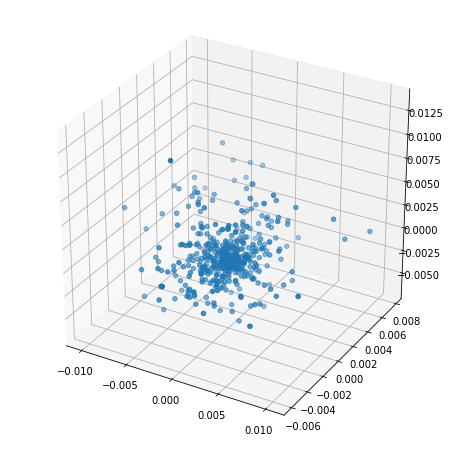

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca.fit(user_embeddings)
user_embeddings_pca = pca.transform(user_embeddings)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = "3d")
xs, ys, zs = user_embeddings_pca[::150].T
ax.scatter(xs, ys, zs)

<pre>
# Copyright 2018 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>